<a href="https://colab.research.google.com/github/Dev-hottae/PINC/blob/master/Data_Analysis/Estimation_KoBERT_News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls drive/'My Drive'/'Colab Notebooks'/

 __MACOSX	  'report.ipynb의 사본의 사본'	     requirements.txt
 NarrativeKoGPT2  'report.ipynb의 사본의 사본 (1)'   Untitled0.ipynb


In [3]:
!pip install -r drive/'My Drive'/'Colab Notebooks'/requirements.txt

     |████████████████████████████████| 348kB 9.8MB/s 
     |████████████████████████████████| 55.0MB 56kB/s 
     |████████████████████████████████| 1.1MB 41.4MB/s 
     |████████████████████████████████| 1.3MB 48.9MB/s 
     |████████████████████████████████| 2.9MB 42.5MB/s 
     |████████████████████████████████| 890kB 42.9MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp36-cp36m-linux_x86_64.whl size=588510 sha256=dd6ad52f8b69bc64f090969f3844f87a57c7472e93c9feef92933987155f3127
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
  Created wheel for kss: filename=kss-1.3.1-cp36-cp36m-linux_x86_64.whl size=251568 sha256=0096eb37a102bc9fd4b76c48ddc216baefafdffcddf844c29a53dd7fe88bf386
  Stored in directory: /root/.cache/pip/wheels/8b/98/d1/53f75f89925cd95779824778725ee3fa36e7aa55ed26ad54a8
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=9d710c3b59402a4801acc79e9e5787876

In [4]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git

  Cloning https://****@github.com/SKTBrain/KoBERT.git to /tmp/pip-req-build-641jwrqa
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-641jwrqa
  Created wheel for kobert: filename=kobert-0.1.1-cp36-none-any.whl size=12825 sha256=348731d77d3fd4628b17742793f640eb93ac5e1c40739025c0303177ae653a76
  Stored in directory: /tmp/pip-ephem-wheel-cache-r489ybec/wheels/43/7b/50/91bc4d7bebb30b62f31a30a537787eb512f27506909162ba14
Successfully built kobert


In [5]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import gluonnlp as nlp
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm import tqdm, tqdm_notebook

In [6]:
from transformers import AdamW, BertModel, BertConfig
from transformers.optimization import get_linear_schedule_with_warmup
from kobert.utils import get_tokenizer, download, tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

In [7]:
#GPU 사용
device = torch.device("cuda:0")

In [8]:
ctx= 'cuda'
cachedir='~/kogpt2/'

load_path = '/content/drive/My Drive/머신러닝/팀 프로젝트/06. AI를 이용한 금융 보고서/Data_Analysis/checkpoint/Classification_KoBERT_checkpoint5.tar'

pytorch_kobert = {
    'url': 'https://kobert.blob.core.windows.net/models/kobert/pytorch/pytorch_kobert_2439f391a6.params',
    'fname': 'pytorch_kobert_2439f391a6.params',
    'chksum': '2439f391a6'
}

bert_config = {
    'attention_probs_dropout_prob': 0.1,
    'hidden_act': 'gelu',
    'hidden_dropout_prob': 0.1,
    'hidden_size': 768,
    'initializer_range': 0.02,
    'intermediate_size': 3072,
    'max_position_embeddings': 512,
    'num_attention_heads': 12,
    'num_hidden_layers': 12,
    'type_vocab_size': 2,
    'vocab_size': 8002
}

In [9]:
# download model
model_info = pytorch_kobert
model_path = download(model_info['url'],
                      model_info['fname'],
                      model_info['chksum'],
                      cachedir=cachedir)
# download vocab
vocab_info = tokenizer
vocab_path = download(vocab_info['url'],
                      vocab_info['fname'],
                      vocab_info['chksum'],
                      cachedir=cachedir)

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]


In [12]:
# Device 설정
device = torch.device(ctx)

# 저장한 Checkpoint 불러오기
checkpoint = torch.load(load_path, map_location=device)

# KoGPT-2 언어 모델 학습을 위한 GPT2LMHeadModel 선언
model = BertModel(config=BertConfig.from_dict(bert_config))
model.state_dict(checkpoint['model_state_dict'])

# 생성을 위해 Eval 선언
model.eval()
# 단어 뭉치 가져오기
vocab = nlp.vocab.BERTVocab.from_sentencepiece(vocab_path,
                                               padding_token='[PAD]')

In [13]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

[██████████████████████████████████████████████████]


In [14]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [15]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2, # 해당 부분 파라미터 조정으로 다중 분류 가능
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [17]:
model = BERTClassifier(model,  dr_rate=0.5).to(device)

In [18]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [20]:
optimizer = AdamW(optimizer_grouped_parameters, lr=0)
loss_fn = nn.CrossEntropyLoss()

In [21]:
data_path = '/content/drive/My Drive/머신러닝/팀 프로젝트/06. AI를 이용한 금융 보고서/Data_Analysis/DataSet/sample_label_by1.csv'

In [24]:
news_data = pd.read_csv(data_path, encoding='utf-8', index_col=0)
news_data = news_data[['date', 'text']]
news_data = news_data.reset_index()
news_data = news_data.drop(['Unnamed: 0'], axis=1)
news_data.head()

,date,text
0,2003-08-01,하이닉스 주가가 급반등했다. 1일 오후 2시23분 현재 하이닉스는 전날보다 1천1...
1,2003-08-01,거래소시장에서 종합지수가 美 경제지표의 호전에 고무된 외국인 매수로 연중 고점을 ...
2,2003-08-01,반도체주들이 강보합권에 개장했다. 1일 오전 9시5분 현재 삼성전자는 전날보다 3...
3,2003-08-01,1일 전기전자업종은 외국인 매수에 힘입어 삼성전자가 연중 고점을 경신하는 등 대부...
4,2003-08-04,반도체주들이 약세권에 개장했다. 4일 오전 9시5분 현재 삼성전자는 전날보다 5천...


In [25]:
predict_dataset = []
for i in tqdm(range(len(news_data))):
    predict_dataset.append([news_data['text'][i]])
len(predict_dataset)

100%|██████████| 15678/15678 [00:00<00:00, 145201.55it/s]


15678

In [26]:
transform = nlp.data.BERTSentenceTransform(tok, max_seq_length=64, pad=True, pair=False)
sentences = [transform(i) for i in predict_dataset]

In [27]:
predict_dataloader = torch.utils.data.DataLoader(sentences, batch_size=64, num_workers=10)

In [28]:
result_out = []
for batch_id, (token_ids, valid_length, segment_ids) in enumerate(tqdm_notebook(predict_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    out = model(token_ids, valid_length, segment_ids)
    max_vals, max_indices = torch.max(out, 1)
    result_out.append(max_indices)
len(result_out)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


245

In [29]:
# 예측 결과
predict = []
for i in tqdm(result_out):
    for j in i:
        predict.append(j.item())
len(predict)

100%|██████████| 245/245 [00:00<00:00, 944.83it/s]


15678

In [35]:
predict_result = pd.DataFrame(predict, columns=['predict'])
predict_news = pd.concat([news_data, predict_result], axis=1)
predict_news.head()

,date,text,predict
0,2003-08-01,하이닉스 주가가 급반등했다. 1일 오후 2시23분 현재 하이닉스는 전날보다 1천1...,1
1,2003-08-01,거래소시장에서 종합지수가 美 경제지표의 호전에 고무된 외국인 매수로 연중 고점을 ...,1
2,2003-08-01,반도체주들이 강보합권에 개장했다. 1일 오전 9시5분 현재 삼성전자는 전날보다 3...,1
3,2003-08-01,1일 전기전자업종은 외국인 매수에 힘입어 삼성전자가 연중 고점을 경신하는 등 대부...,0
4,2003-08-04,반도체주들이 약세권에 개장했다. 4일 오전 9시5분 현재 삼성전자는 전날보다 5천...,1


In [36]:
news_predict = predict_news['predict'].groupby(predict_news['date']).mean()
news_predict = pd.DataFrame(news_predict)
news_predict.head()

,predict
date,
2003-08-01,0.750000
2003-08-04,1.000000
2003-08-06,0.500000
2003-08-07,0.333333
2003-08-08,0.500000


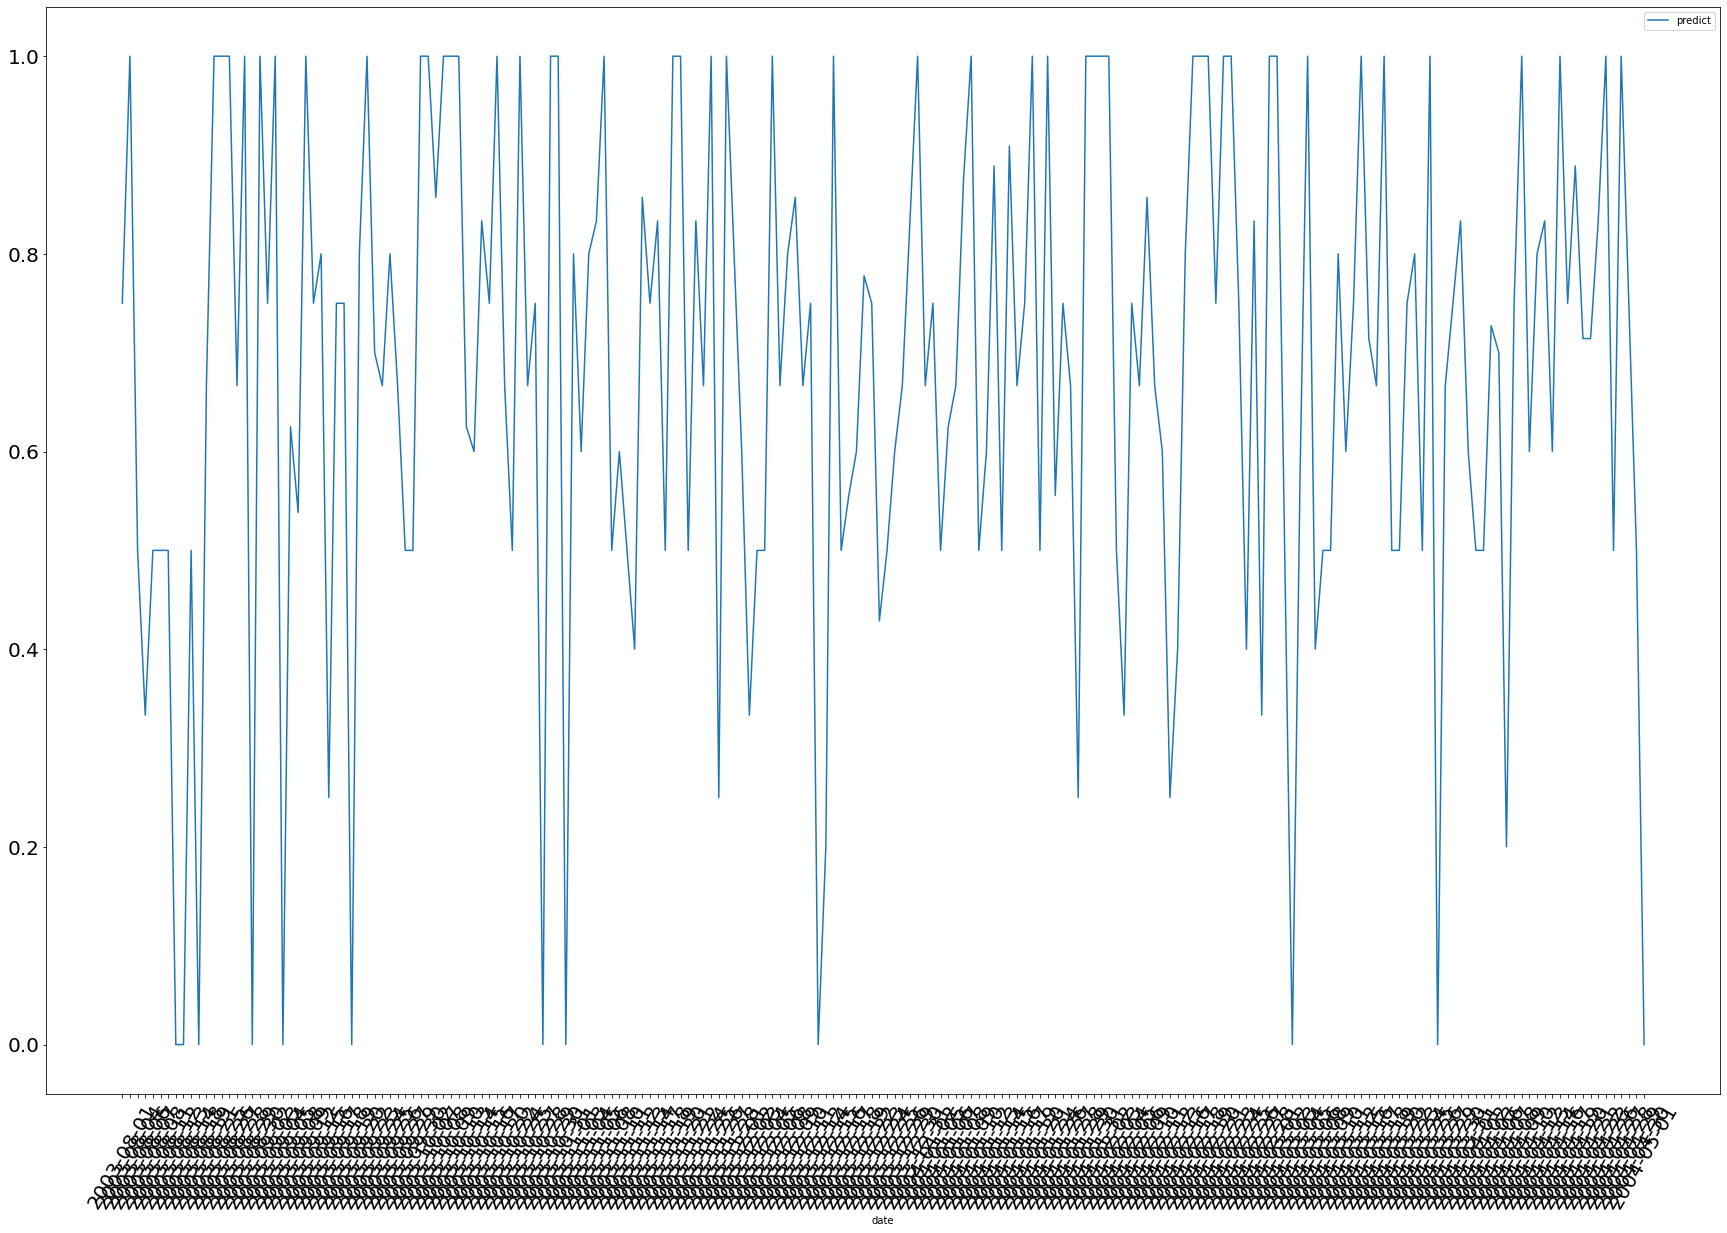

In [40]:
plt.figure(figsize=(30, 20))
sns.lineplot(data = news_predict[0:200])
plt.xticks(rotation = 60, fontsize = 10)
plt.tick_params(labelsize=20)